## Necessary preparations

In [129]:
import numpy as np
import pandas as pd
import torch

import PIL
print(PIL.PILLOW_VERSION)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

5.4.1
CUDA is available!  Training on GPU ...


In [130]:
import pickle
import numpy as np
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [131]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [132]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [133]:
print(torch.__version__)

1.3.0


# Dataset construction

In [134]:
class SimpsonsDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])
    # трансформации для шума
    custom_augmentations_01 = transforms.RandomOrder([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.25),
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.25), ratio=(0.8, 1.25))], p=0.25),
    transforms.RandomApply([transforms.RandomAffine((-10,10), (0.1,0.1))], p=0.25),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.25),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.02,contrast=0.02,saturation=0.02,hue=(-0.02, 0.02))], p=0.01)
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    #x = np.array(x / 255, dtype='float32')

    
    if self.mode == 'test':
        x = np.array(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x
    else:
        
        if self.mode == 'train':
            x = custom_augmentations_01(x)
            
        x = transform(x)
        
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return image #np.array(image)

In [135]:
TRAIN_DIR = Path('/kaggle/input/simpsons4/train')
TEST_DIR = Path('/kaggle/input/simpsons4/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Тренируем модель на всей выборке, чтобы точно задействовать все классы. При этом валидационная выборка - это 30 процентов от тех же данных, НО аугментируем мы только тренировочную часть.

In [136]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

train_files = shuffle(train_val_files, random_state=0) #!!!

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

# Let's take a look at our data

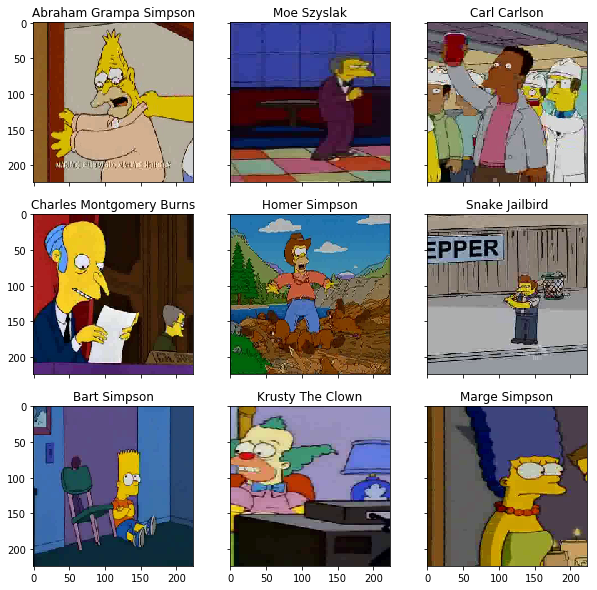

In [137]:
    
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    

# Building the model

Импортируем готовую resnet34 и заменим последний слой.

In [138]:
from torchvision import models

model = models.resnet34(pretrained=True)
#model = models.resnet18(pretrained=True)

In [139]:
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=42)

In [140]:
model = model.to(DEVICE)

Создадим циклический lr_scheduler:

In [141]:
import math

def cyclical_lr(stepsize, min_lr=1e-3, max_lr=1e-2):
    
    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.
    
    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)
    print('cycle')
    return lr_lambda

Функции для обучения, проверки, предсказаний.

In [142]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step() # потому что pytorch.__version__ > 1.1.0
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        #***************************************************        
        #opt = torch.optim.Adam(model.parameters())

        #criterion = nn.CrossEntropyLoss()

        #***************************************************
        criterion = nn.CrossEntropyLoss()
        #opt = torch.optim.SGD(model.parameters(), lr=1.)
        opt = torch.optim.Adam(model.parameters())
        step_size = 10*len(train_loader)
        clr = cyclical_lr(step_size)
        clr_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])
        #***************************************************

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, clr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [143]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Actual training

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

cycle
loss 3.7535036235146544


epoch:   5%|▌         | 1/20 [03:58<1:15:40, 238.96s/it]


Epoch 001 train_loss: 3.7535     val_loss 3.3938 train_acc 0.0281 val_acc 0.0946
loss 1.554902995133205


epoch:  10%|█         | 2/20 [07:55<1:11:26, 238.13s/it]


Epoch 002 train_loss: 1.5549     val_loss 0.7445 train_acc 0.6279 val_acc 0.8239
loss 0.6358150311669669


epoch:  15%|█▌        | 3/20 [11:51<1:07:16, 237.45s/it]


Epoch 003 train_loss: 0.6358     val_loss 0.4181 train_acc 0.8419 val_acc 0.8943
loss 0.4281362249820133


epoch:  20%|██        | 4/20 [15:46<1:03:10, 236.88s/it]


Epoch 004 train_loss: 0.4281     val_loss 0.2862 train_acc 0.8909 val_acc 0.9283


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

Наконец, посмотрим на график:

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
fig = plt.figure(figsize=(20, 15))

losses = fig.add_subplot(2,2,3)
losses.plot(loss, label="train_loss")
losses.plot(val_loss, label="val_loss")
losses.legend(loc='best')
losses.grid(axis = 'y')
losses.set_xlabel("epochs")
losses.set_ylabel("loss")

accs = fig.add_subplot(2,2,4)
accs.plot(acc, label="train_acc")
accs.plot(val_acc, label="val_acc")
accs.legend(loc='best')
accs.grid(axis = 'y')
accs.set_xlabel("epochs")
accs.set_ylabel("accuracy")

plt.show()

# Submission

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit

In [0]:
submit.to_csv('model-resnet34_train100_batch64_epoch20.csv', index=False)